In [1]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

2.12.0


In [43]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import src.relabel_data as rd
import cv2
import numpy as np
from src.create_augment import createAugment
from keras.models import load_model
from keras.utils import CustomObjectScope
from PIL import Image, ImageDraw

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# get the new data after filtering and relabeling
x_train, y_train, x_test, y_test = rd.filter_relabel(x_train, y_train, x_test, y_test)

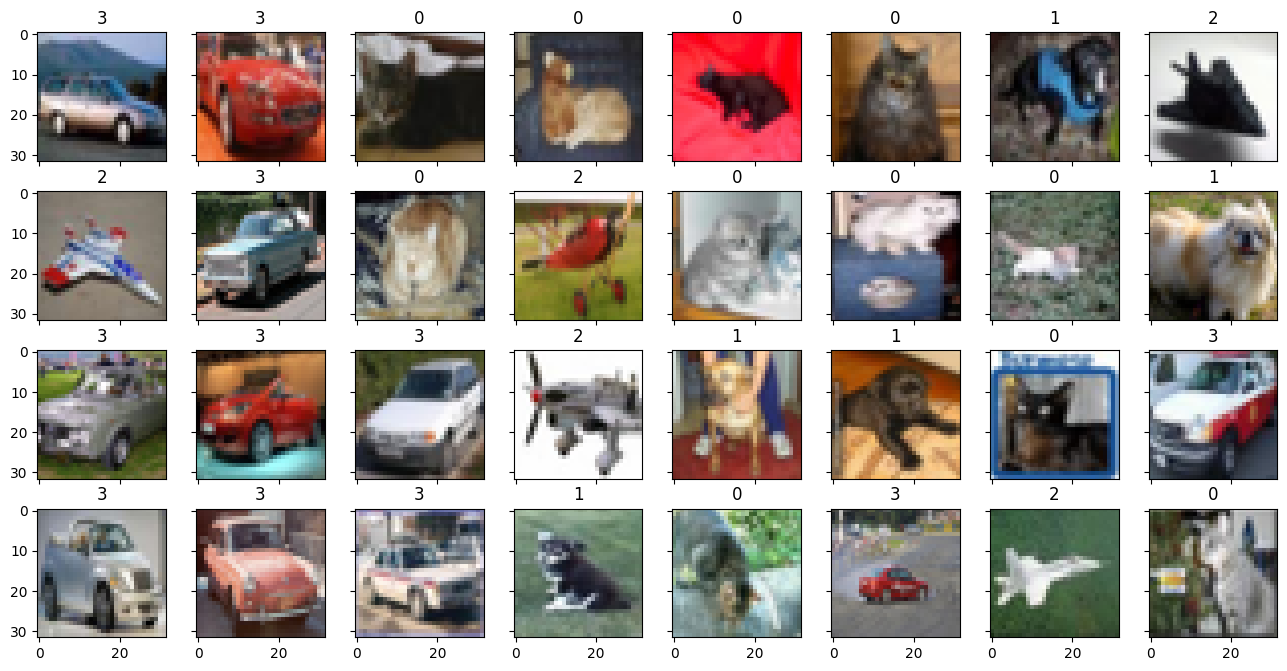

In [9]:
############## plot the images ##############

sample_images = x_train[:32]
sample_labels = y_train[:32]
fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image, label in zip(grid, sample_images, sample_labels):
  ax.imshow(image)
  ax.set_title(label[0])

plt.show()


In [10]:
train_masked = createAugment(x_train, x_train)
test_masked = createAugment(x_test, x_test)

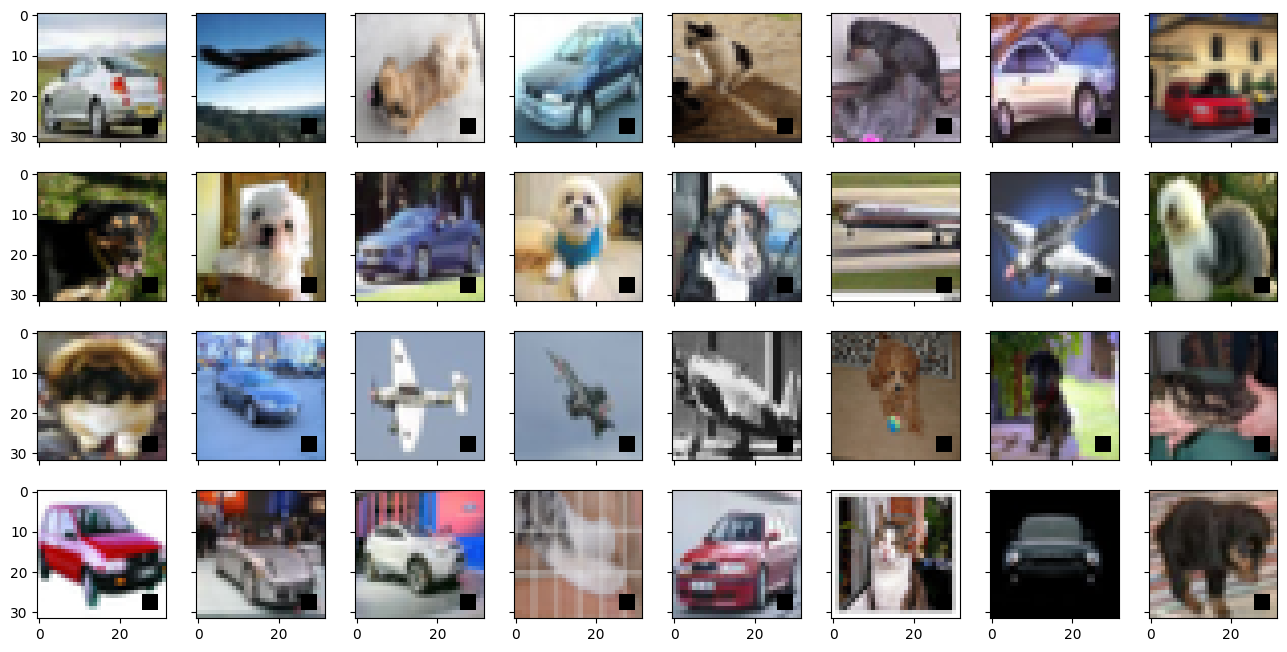

In [11]:
## Examples
sample_idx = 100 ## Change this to see different batches

sample_images, sample_labels = train_masked[sample_idx]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

In [10]:
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) + 1)

In [13]:
def unet_simple():
    inputs = keras.layers.Input((32, 32, 3))

    # Encoding / Downsampling
    conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    # Decoding / Upsampling
    up4 = keras.layers.concatenate([keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3), conv2], axis=3)
    conv4 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up4)

    up5 = keras.layers.concatenate([keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv4), conv1], axis=3)
    conv5 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up5)

    # Output
    outputs = keras.layers.Conv2D(3, (1, 1), activation='sigmoid')(conv5)

    return keras.models.Model(inputs=[inputs], outputs=[outputs]) 

In [14]:
keras.backend.clear_session()
model = unet_simple()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   18496       ['max_pooling2d[0][0]']          
                                                                                              

In [ ]:
model.fit(train_masked, validation_data=test_masked, 
          epochs=20, 
          steps_per_epoch=len(train_masked), 
          validation_steps=len(test_masked),
          use_multiprocessing=True)

In [ ]:
model.save('simple_Unet.h5')

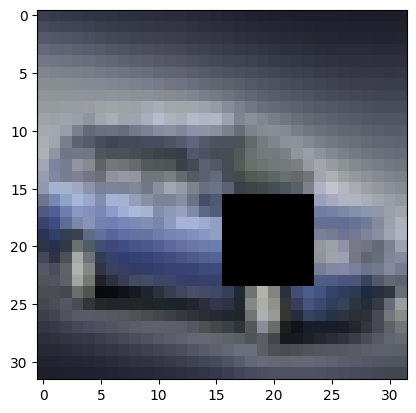

In [ ]:
plt.imshow(sample_images[0])

1/1 [==============================] - 0s 13ms/step


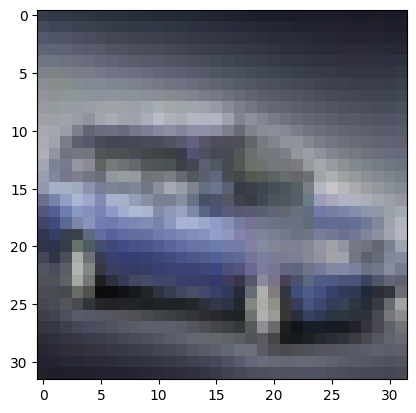

In [ ]:
im = sample_images[0]
impainted_image = model.predict(im.reshape((1,)+im.shape))
plt.imshow(impainted_image.reshape(impainted_image.shape[1:]))


1/1 [==============================] - 0s 10ms/step


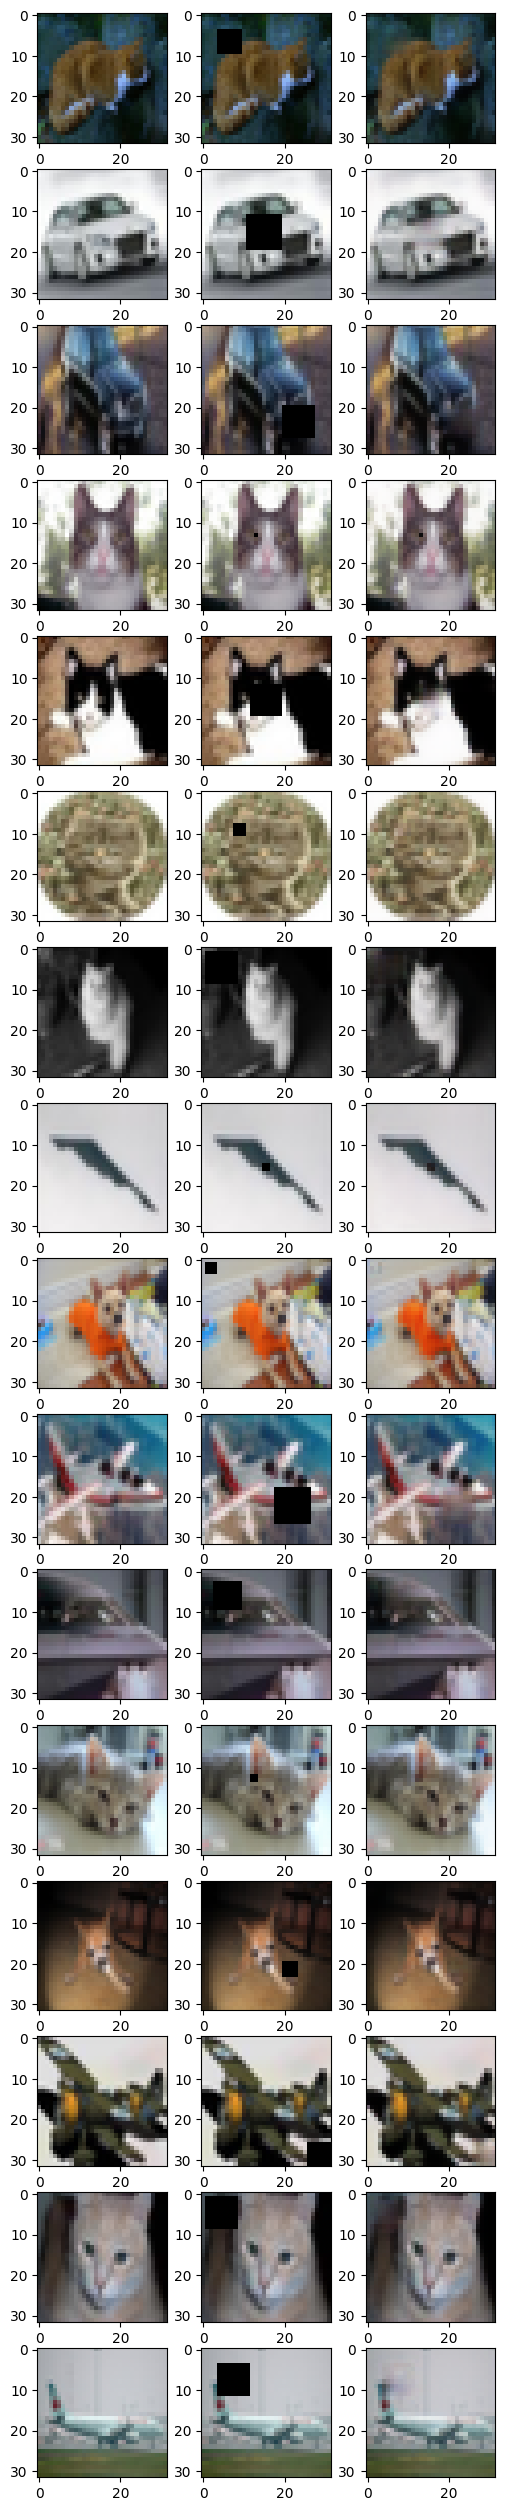

In [ ]:
## Examples
rows = 16
sample_idx = np.random.randint(0, len(test_masked), rows)

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 32))

for i, idx in enumerate(sample_idx):
  sample_images, sample_labels = train_masked[idx]
  img_idx = np.random.randint(0, len(sample_images)-1, 1)[0]
  impainted_image = model.predict(sample_images[img_idx].reshape((1,)+sample_images[img_idx].shape))
  axs[i][0].imshow(sample_labels[img_idx])
  axs[i][1].imshow(sample_images[img_idx])
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))

plt.show()

### Test with real-life picture

In [5]:
from PIL import Image

def resize_image(input_image_path, output_image_path, size):
    original_image = Image.open(input_image_path)
    width, height = original_image.size
    print(f'The original image size is {width} wide x {height} tall')

    resized_image = original_image.resize(size)
    width, height = resized_image.size
    print(f'The resized image size is {width} wide x {height} tall')
    #resized_image.show()
    resized_image.save(output_image_path)

# Call the function
resize_image('test.jpg', 'test_resized.jpg', (32, 32))

The original image size is 1170 wide x 1200 tall
The resized image size is 32 wide x 32 tall


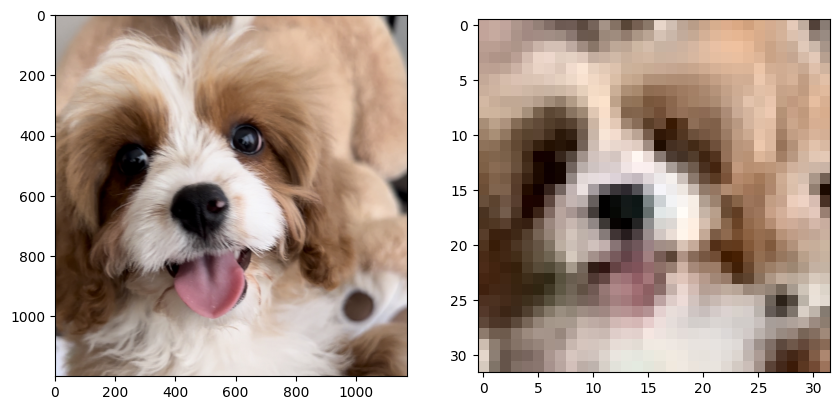

In [93]:
import matplotlib.image as mpimg

# Read the image file
img = mpimg.imread('test.jpg')
img_resized = mpimg.imread('test_resized.jpg')
# Display the image

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].imshow(img)
axs[1].imshow(img_resized)

In [94]:
# Load the model
with CustomObjectScope({'dice_coef': dice_coef}):
    model = load_model('simple_Unet.h5')

In [101]:
#Load the resized the image for testing
img_resized = Image.open('test_resized.jpg')
img_resized = np.array(img_resized)

test_dog = img_resized.reshape((1,)+img_resized.shape)

# Add mask to the picture
test_dog_masked = createAugment(test_dog, test_dog)
test_dog_image, test_dog_labels = test_dog_masked[0]

In [102]:
# Fit the model
img_resized_pred = model.predict(test_dog_image[0].reshape((1,)+test_dog_image[0].shape))

1/1 [==============================] - 0s 15ms/step


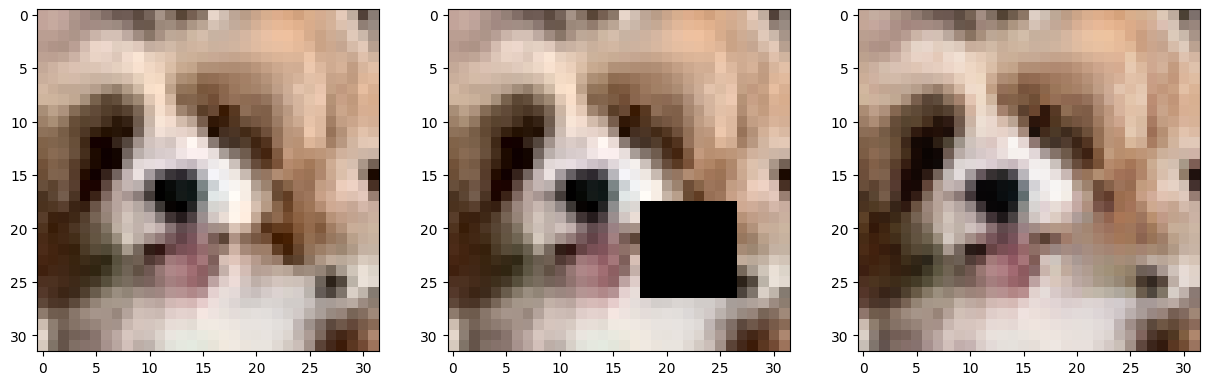

In [103]:
# Plot the results
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axs[0].imshow(img_resized)
axs[1].imshow(test_dog_image[0])
axs[2].imshow(img_resized_pred.reshape(img_resized_pred.shape[1:]))

plt.show()